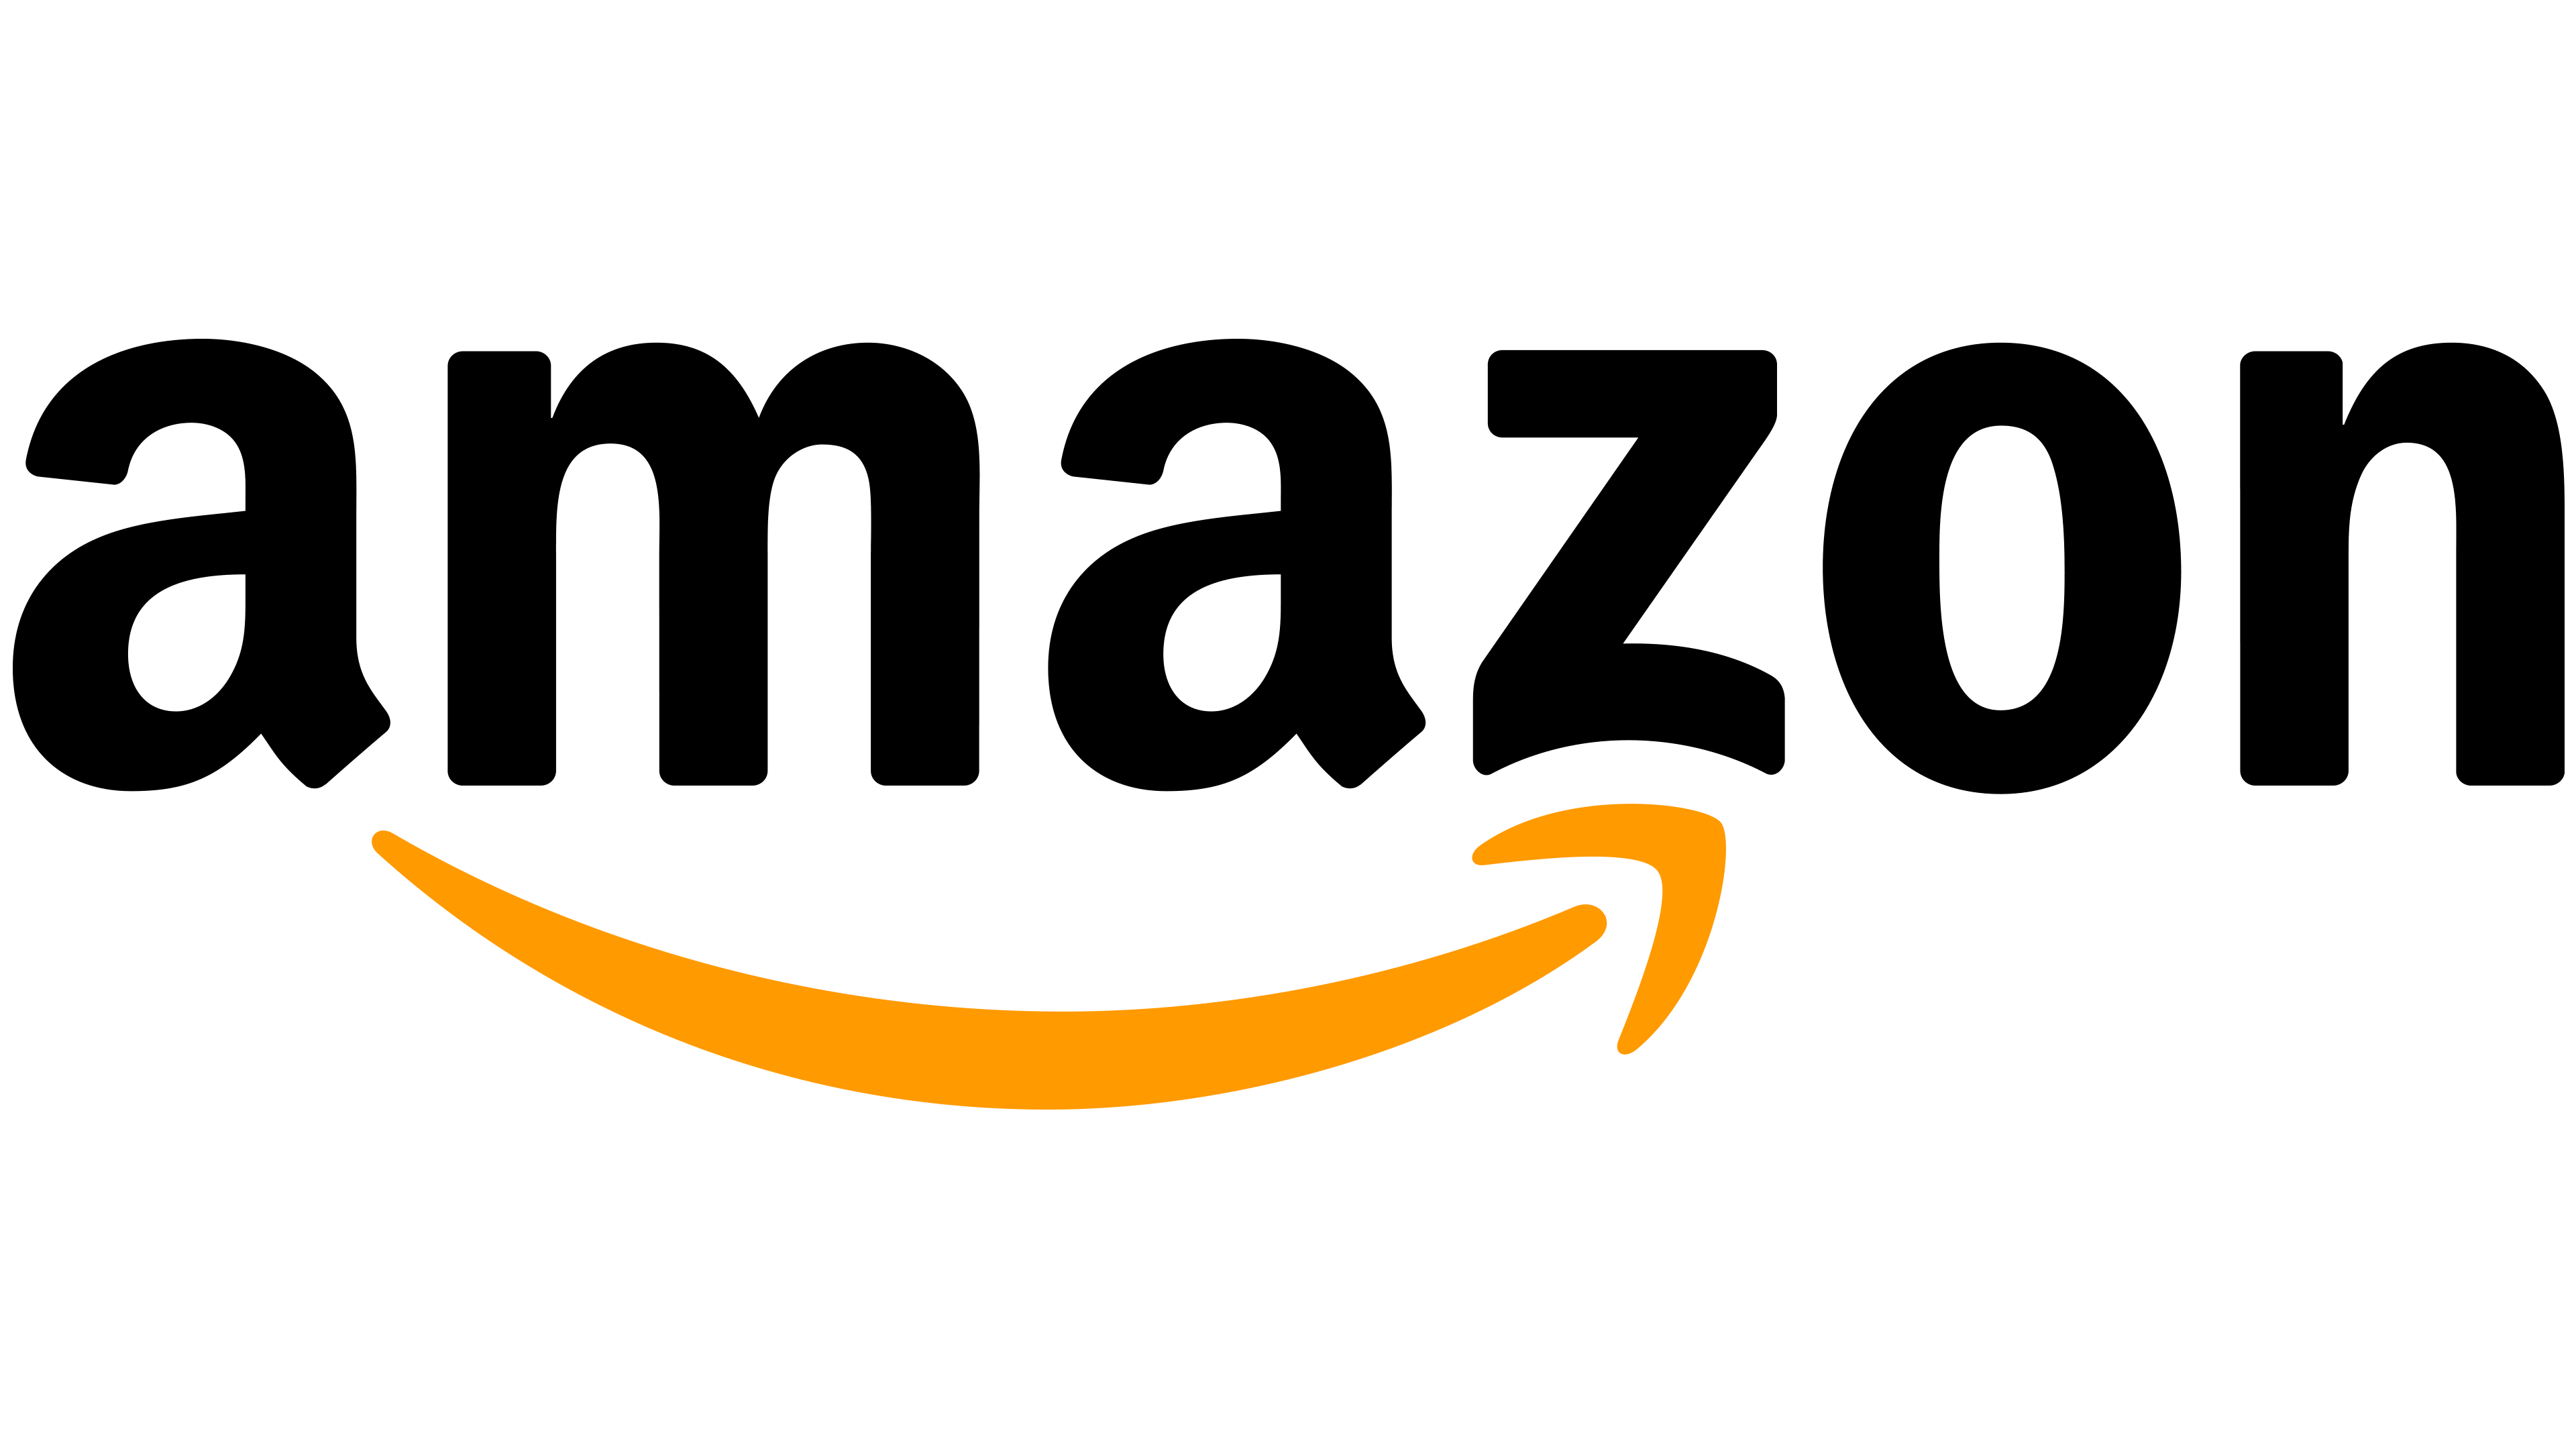

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**


#### El proyecto consta de las siguientes etapas

```Parte 1```   
    
    1-Importacion y estado de salud del dataset
    
    2- Analisis exploratorio de datos
        a.Analisis general
        b.Peliculas mal puntuadas
        c.Peliculas bien puntuadas
    
    3- Preparacion de datos
        a-Stemming
        b.Vectorizer
        
    4- Modelos de clasificacion
        a.GaussianNB - Modelo benchmark
        b.Arbol de decision
        c.Random forest
        
    5- Probando con otra transformacion de datos
        a.Lemmantization
        b.Implementacion del mejor modelo (Punto 4)
        
```Parte 2: ¿Se pueden mejorar los resultados con deep learning?```
    
    1-Modelos de deep learning con la misma cantidad de datos
        a.Stemming
        b.Lemmantization
        
    2-Modelos de deep learning con mas cantidad de datos
        a.Stemming
        b.Lemmantization 

# 1- Importación y estado de salud del dataset 

In [1]:
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from funpymodeling.exploratory import status,freq_tbl,profiling_num,cat_vars, num_vars,corr_pair
import nltk
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import math
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils, plot_model
from keras.regularizers import l1
from keras.layers import Embedding, Flatten, Dropout
from keras.layers import Embedding, Flatten, Dropout
import keras
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# let's keep our keras backend tensorflow quiet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
dataset = pd.read_json("C:/Users/Usuario/Desktop/Cursos/Data science - Acamica/Proyecto 4/dataset_amazon/dataset_es_train.json",lines=True)

In [3]:
dataset.head(3)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore


In [4]:
print (f"El dataset contiene {dataset.shape[0]} filas y {dataset.shape[1]} columnas")

El dataset contiene 200000 filas y 8 columnas


In [5]:
status(dataset)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,review_id,0,0.0,0,0.0,200000,object
1,product_id,0,0.0,0,0.0,150938,object
2,reviewer_id,0,0.0,0,0.0,179076,object
3,stars,0,0.0,0,0.0,5,int64
4,review_body,0,0.0,0,0.0,198264,object
5,review_title,0,0.0,0,0.0,112114,object
6,language,0,0.0,0,0.0,1,object
7,product_category,0,0.0,0,0.0,30,object


# 2- Analisis exploratorio de datos

## A- Analisis general

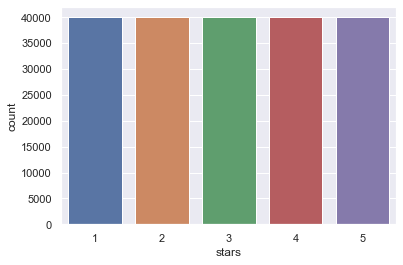

In [6]:
sns.countplot(data = dataset, x = 'stars')
plt.show()

Vemos que la variable stars, que es la puntuacion asignada por el usuario, esta balanceada. Por lo que nos va a facilitar el tratamiento de datos para luego realizar las predicciones

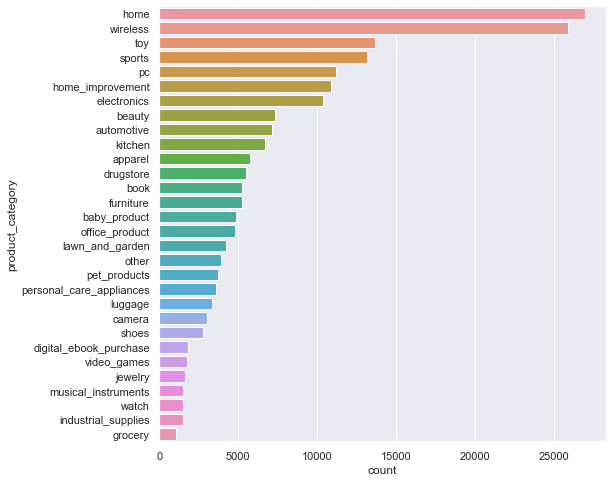

In [7]:
plt.figure(figsize=(8,8))
sns.countplot(data = dataset, y = 'product_category',order =dataset["product_category"].value_counts().index)
plt.show()

En este grafico, podemos observar de que categoria son los productos calificados por los usuarios. Mayormente pertenecen a articulos del hogar, conectividad, juguetes y deportes.

In [8]:
dataset["language"].value_counts()

es    200000
Name: language, dtype: int64

Todas las calificaciones son en español. Con esto podemos definir el lenguaje que vamos a utilizar para implementar el modelo de NLP.

In [9]:
pd.crosstab(dataset["product_category"],dataset["stars"],normalize = 'index').sort_values(by = 5, ascending = False)

stars,1,2,3,4,5
product_category,,,,,
book,0.125190,0.170213,0.189590,0.210106,0.304901
video_games,0.202539,0.178304,0.175995,0.178304,0.264859
grocery,0.168582,0.193487,0.205939,0.185824,0.246169
luggage,0.135517,0.174880,0.195913,0.247897,0.245793
other,0.200406,0.179070,0.199644,0.182118,0.238760
digital_ebook_purchase,0.098752,0.172545,0.240369,0.249593,0.238741
musical_instruments,0.152941,0.178431,0.195425,0.236601,0.236601
pc,0.198374,0.192029,0.177643,0.212582,0.219373
office_product,0.181094,0.191574,0.203521,0.207294,0.216516


Lo que vemos en este cuadro es que la categoria que mas calificaciones tiene con una puntuacion de 5 es la de libros. Sin embargo, esta forma de verlo no termina de ser concluyente, ya que se ve afectada por la cantidad de calificaciones que haya tenido esa categoria. 
Para que puedan ser comparables entre si todas la categorias, vamos a ver la calificacion promedio de cada categoria.

In [10]:
dataset.groupby("product_category")["stars"].mean().sort_values(ascending = False)

product_category
book                        3.399316
digital_ebook_purchase      3.357027
luggage                     3.293570
musical_instruments         3.225490
grocery                     3.147510
video_games                 3.124639
shoes                       3.109296
camera                      3.109277
baby_product                3.089326
office_product              3.086565
other                       3.079756
industrial_supplies         3.078947
pc                          3.062550
furniture                   3.048958
toy                         3.042061
home_improvement            3.036584
sports                      3.034650
personal_care_appliances    3.022950
kitchen                     3.016281
drugstore                   3.010521
watch                       3.001342
pet_products                2.991112
home                        2.980380
automotive                  2.950721
beauty                      2.935805
jewelry                     2.930538
electronics          

Viendo la calificacion promedio de cada categoria, vemos que los libros se mantienen en el primer lugar, siendo la categoria mas recomendada por los usuarios de amazon. Las categorias siguientes son los libros digitales, equipajes e instrumentos digitales.

## B- Bad movies

Vamos a hacer una pequeña profundizacion en la publicaciones con peor calificacion, que son aquellas que tengan 1 estrella.

In [11]:
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]
#stopwords

In [12]:
filtrar = []
if True:
    filtrar.append("u")
    filtrar.append("new")

In [13]:
dataset_bad = dataset[dataset.stars==1]
dataset_bad.head()

all_bad_reviews = []
for i in range(dataset_bad.shape[0]):
    review = dataset_bad.iloc[i].review_body.lower()
    review = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(review)
    review = [word for word in review if word not in stopwords]
    review = [word for word in review if word not in filtrar]

    all_bad_reviews.append(review)

In [14]:
bad_reviews = list(itertools.chain(*all_bad_reviews))

freq_bad_reviews = nltk.FreqDist(bad_reviews)

df_bad_reviews = pd.DataFrame(list(freq_bad_reviews.items()), columns = ["Word","Frequency"])
df_bad_reviews.sort_values('Frequency',ascending=False, inplace = True)
df_bad_reviews.reset_index(drop = True, inplace=True)

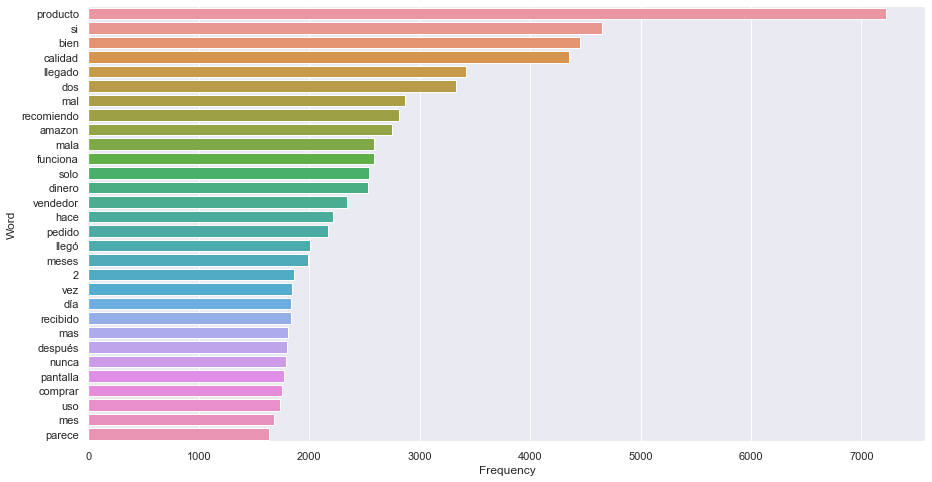

In [15]:
plt.figure(figsize = (15,8))
plot = sns.barplot(y  = df_bad_reviews.iloc[:30].Word, x = df_bad_reviews.iloc[:30].Frequency)
plt.show()

Haciendo este analisis rapido, podemos ver como aparecen repetidas palabras como mal, mala, dinero

## C- Good movies

Vamos a replicar lo que hicimos con las compras mal calificadas, pero con las que tienen mejor calificacion (5 estrellas)

In [16]:
dataset_good = dataset[dataset.stars==5]
dataset_good.head()

all_good_reviews = []
for i in range(dataset_good.shape[0]):
    review = dataset_good.iloc[i].review_body.lower()
    review = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(review)
    review = [word for word in review if word not in stopwords]
    review = [word for word in review if word not in filtrar]

    all_good_reviews.append(review)

In [17]:
good_reviews = list(itertools.chain(*all_good_reviews))

freq_good_reviews = nltk.FreqDist(good_reviews)

df_good_reviews = pd.DataFrame(list(freq_good_reviews.items()), columns = ["Word","Frequency"])
df_good_reviews.sort_values('Frequency',ascending=False, inplace = True)
df_good_reviews.reset_index(drop = True, inplace=True)

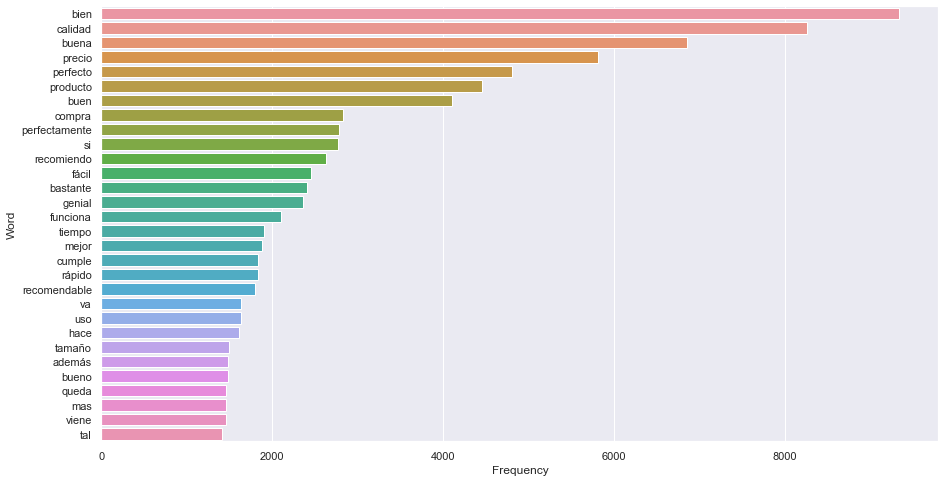

In [18]:
plt.figure(figsize = (15,8))
plot = sns.barplot(y  = df_good_reviews.iloc[:30].Word, x = df_good_reviews.iloc[:30].Frequency)
plt.show()

Aca lo que podemos ver es como aparecen palabras como bien, buena, perfecto, diferenciandose en gran medida de las peores calificaciones

# 3- Preparacion de datos

## A- Stemming

In [19]:
snow_stemmer = SnowballStemmer(language='spanish')
stopwords = nltk.corpus.stopwords.words('spanish')

In [20]:
# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
reviews_list=[]
for review in dataset.review_body:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    review = re.sub("[^a-zA-Z]"," ",str(review))
    # Pasamos todo a minúsculas
    review=review.lower()
    # Tokenizamos para separar las palabras del titular
    review=nltk.word_tokenize(review)
    # Eliminamos las palabras de menos de 3 letras
    review = [palabra for palabra in review if len(palabra)>3]
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    review=[snow_stemmer.stem(palabra) for palabra in review]
    # Por ultimo volvemos a unir el titular
    review=" ".join(review)
    
    # Vamos armando una lista con todos los titulares
    reviews_list.append(review)
    #dataset["titular_normalizado"] = titular_list


In [21]:
dataset_stem = dataset.copy()
dataset_stem["review_stem"] = reviews_list
dataset_stem=pd.concat([dataset_stem.review_stem,dataset_stem.stars],axis=1)
dataset_stem.head()

,review_stem,stars
0,buen pantall men mes recib respuest fabric,1
1,horribl compr sab ingl inform tic despu hor ca...,1
2,oblig compr unidad lleg sol form reclam autent...,1
3,entro descalific vendedor sol pued dec tras me...,1
4,lleg tard tall equivoc,1


## B - Vectorizer

### Con las reviews previamente stemizadas

In [22]:
max_features= 2500
cou_vec=CountVectorizer(max_features=max_features,ngram_range=(1, 2))

In [23]:
list_reviews = list(dataset_stem['review_stem'].values)
stars = dataset_stem['stars'].values

In [24]:
matriz_reviews = cou_vec.fit_transform(list_reviews)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()


print("Las 50 palabras mas usadas son: ",all_words[0:50])

Las 50 palabras mas usadas son:  ['abaj', 'abiert', 'aboll', 'abon', 'abre', 'abren', 'abres', 'abrig', 'abril', 'abrir', 'abrirl', 'absolut', 'absorb', 'abult', 'aburr', 'acab', 'acab buen', 'acab recib', 'acced', 'acces', 'accesori', 'aceit', 'acept', 'acer', 'acerc', 'acert', 'aciert', 'aclar', 'acolch', 'acomp', 'acondicion', 'aconsej', 'aconsej compr', 'acopl', 'acopl bien', 'acord', 'acostumbr', 'activ', 'actual', 'actualiz', 'adapt', 'adapt bien', 'adapt perfect', 'adecu', 'adel', 'adem', 'adem lleg', 'adem vien', 'adherent', 'adhes']


Luego de haber hecho la preparacion de datos, ya estamos en condiciones de implementar modelos de clasificacion.

# 4 - Modelos ML - Clasificacion

En los modelos que vamos a implementar, el objetivo es que reciba como input el vector que acabamos de preparar y genere como output un valor de 1 a 5, siendo esta la clasificacion del producto.

Las metricas que vamos a tener en cuenta para ver como esta funcionando el modelo son dos:

1-Accuracy: Esta metrica nos va a permitir ver en que proporcion estamos acertando exactamente al valor clasificado por el usuario.

2-RMSE: Esta metrica nos va a permitir ver el valor promedio por el cual estamos errandole en la prediccion. A esta metrica le vamos a dar mas preponderancia que a el accuracy.

In [25]:
x = matriz_reviews.toarray()
y = stars
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [26]:
xtrain.shape

(160000, 2500)

In [27]:
xtest.shape

(40000, 2500)

## A - GaussianNB - Modelo benchmark

Creamos el modelo gaussiano con sus hiperparemetros por defecto y lo entrenamos.

In [29]:
nb = GaussianNB()
nb.fit(xtrain,ytrain)

GaussianNB()

Realizamos las predicciones sobre el conjunto de test

In [30]:
y_pred_bench=nb.predict(xtest)

Vemos el accuracy del modelo benchmark

In [31]:
print("accuracy: ",accuracy_score(ytest,y_pred_bench))

accuracy:  0.3941


Vemos el RMSE del modelo benchmark

In [32]:
mse0 = mean_squared_error(ytest,y_pred_bench)
rmse0 = math.sqrt(mse0)
print("RMSE: ",rmse0)

RMSE:  1.5348126921549743


## B- ARBOL DE DECISION

Creamos el modelo de arbol de decision con sus hiperparametros por defecto y lo entrenamos

In [33]:
gs_tree0 = DecisionTreeClassifier()

In [34]:
gs_tree0.fit(xtrain,ytrain)

DecisionTreeClassifier()

Realizamos las predicciones sobre el conjunto de test

In [35]:
y_test_pred_tree0 = gs_tree0.predict(xtest)

Vemos el accuracy del modelo con los hiperparametros por defecto

In [36]:
print("accuracy: ",accuracy_score(ytest,y_test_pred_tree0))

accuracy:  0.364475


Vemos el RMSE del modelo con los hiperparametros por defecto

In [37]:
mse1 = mean_squared_error(ytest,y_test_pred_tree0)
rmse1 = math.sqrt(mse1)
print("RMSE: ",rmse1)

RMSE:  1.399517774092205


Podemos observar que con tan solo cambiar el modelo, utilizando los hiperparametros por defecto, dos diferentes impactos:
+ Accuracy: Hubo una caida del 7% en este indicador
+ RMSE: Hubo una mejora del 8,8%

Esto quiere decir que, estamos prediciendo en menor cantidad de casos la calificacion exacta, pero en los casos mal calificados, predecimos en promedio con menos diferencia

Vamos a hacer una optimizacion de los hiperparametros del modelo a traves de la tecnica de random search con validacion cruzada

Creamos la grilla con los posibles hiperparametros

In [38]:
gs_tree = DecisionTreeClassifier()
param_grid_tree = {'criterion':['gini'],
              'max_depth': np.arange(1,50), 
              'min_samples_split': np.arange(2,10),
              'min_samples_leaf': np.arange(1,5)
             }
scoring2 = ['accuracy']

In [39]:
model = RandomizedSearchCV(gs_tree, param_distributions=param_grid_tree, n_iter = 10, cv = 5,scoring = scoring2 ,refit='accuracy')
model.fit(xtrain,ytrain)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_samples_leaf': array([1, 2, 3, 4]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
                   refit='accuracy', scoring=['accuracy'])

In [40]:
print("Mejores parametros: "+str(model.best_params_))

Mejores parametros: {'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 39, 'criterion': 'gini'}


Hacemos la predicciones del mejor modelo encontrado

In [41]:
y_test_pred_tree = model.predict(xtest)

Vemos el accuracy del mejor modelo encontrado

In [42]:
print("accuracy: ",accuracy_score(ytest,y_test_pred_tree))

accuracy:  0.389775


Vemos el RMSE del mejor modelo encontrado

In [43]:
mse = mean_squared_error(ytest,y_test_pred_tree)

rmse = math.sqrt(mse)
print("RMSE: ",rmse)

RMSE:  1.3389921583041478


Habiendo hecho una optimizacion de hiperparametros, la observacion que hacemos sobre las dos metricas elegidas son:

+ Accuracy: Vemos que hubo una caida del 1% respecto al modelo benchmark pero mejoramos un ~7% el modelo de arbol de decision con los hiperparametros por defecto
+ RMSE: Vemos una mejora del 12% en este indicador respecto al modelo benchmark y una mejora del 4% respecto al modelo de arbol de decision con los hiperparametros por defecto

Teniendo en cuenta esto, por el momento es el modelo que mejor performa, por lo que los modelos siguientes, van a ser comparados con este resultado.

## C- RANDOM FOREST

Creamos el modelo de random forest con sus hiperparametros por defecto y lo entrenamos

In [46]:
rf0 = RandomForestClassifier()
rf0.fit(xtrain, ytrain)

RandomForestClassifier()

Realimos las predicciones para el modelo con los hiperparametros por defecto

In [47]:
y_test_pred_rf0 = rf0.predict(xtest)

Vemos el accuracy para el modelo con los hiperparametros por defecto

In [48]:
print("accuracy: ",accuracy_score(ytest,y_test_pred_rf0))

accuracy:  0.43845


Vemos el RMSE para el modelo con los hiperparametros por defecto

In [49]:
mse2 = mean_squared_error(ytest,y_test_pred_rf0)
rmse2 = math.sqrt(mse2)
print("RMSE: ",rmse2)

RMSE:  1.245411578555459


Si comparamos los resultados del modelo de arbol de decision habiendo realizado un optimizacion de sus hiperparametros y el modelo de random forest con sus hiperparametros por defecto, podemos ver que:

+ Accuracy: Hubo una mejora del 12,4% de este indicador, simplemente por utilizar un modelo diferente
+ RMSE: Hubo una mejora del ~7% en este indicador

Vemos que este modelo tuvo mejores resultados que el arbol de decision, por lo que vamos a utilizar estos resultados para compararlo con los modelos siguientes.

Vamos a hacer una optimizacion de los hiperparametros del modelo a traves de la tecnica de random search con una validacion cruzada pequeña para acelerar el procesamiento

Creamos la grilla con los posibles hiperparametros

In [29]:
param_grid_rf = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],#, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800]}#, 1000, 1200, 1400, 1600, 1800, 2000]}

In [31]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid_rf, n_iter = 4, verbose=2,cv = 2, random_state=42, n_jobs = -1)
rf_random.fit(xtrain, ytrain)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed: 91.1min remaining: 151.9min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 96.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 96.0min finished


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=4,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800]},
                   random_state=42, verbose=2)

In [32]:
print("Mejores parametros: "+str(rf_random.best_params_))

Mejores parametros: {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}


In [33]:
print("Mejor Score: "+str(rf_random.best_score_)+'\n')

Mejor Score: 0.4488625



Hacemos la prediccion del mejor modelo encontrado

In [34]:
y_test_pred_rf = rf_random.predict(xtest)

Vemos el accuracy del modelo con una optimizacion de sus hiperparametros

In [62]:
print("accuracy: ",accuracy_score(ytest,y_test_pred_rf))

accuracy:  0.4531


Vemos el RMSE del mejor modelo encontrado

In [35]:
mse1 = mean_squared_error(ytest,y_test_pred_rf)
rmse1 = math.sqrt(mse1)
print("RMSE: ",rmse1)

RMSE:  1.223243638855318


Si comparamos los resultados del modelo random forest con sus hiperparametros por defecto y habiendolos optimizado, podemos ver que:

+ Accuracy: Hay una mejora del 3,3% en este indicador
+ RMSE: Hay una mejora del 1,7% en este indicador

Con estos resultados, podemos concluir que las mejores metricas obtenidas es con un modelo de random forest con los siguientes hiperparametros:
{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}

Con estos resultados, lo que podemos decir es que en el ~45% de las predicciones estamos calificando de manera exacta la review del producto. Y en el ~55% de los casos restantes, estamos errandole en la prediccion por 1,22 puntos en promedio.

# 5- Probando con otra transformacion de datos
Vamos a probar si podemos mejorar los resultados del mejor modelo implementado con la tecnica de stemming, utilizando la tecnica de Lemmantization

## A- Lemmantization

In [28]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [29]:
wordnet_lemmatizer = WordNetLemmatizer()

In [30]:
reviews_list1 =[]
for review in dataset.review_body:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    review=re.sub("[^a-zA-Z]"," ",str(review))
    # Pasamos todo a minúsculas
    review=review.lower()
    # Tokenizamos para separar las palabras
    review=nltk.word_tokenize(review)
    
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in review]
    
    
    # Eliminamos las palabras d emenos de 3 letras
    review = [palabra for palabra in review if len(palabra)>3]
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords]
    
    # Por ultimo volvemos a unir el titular
    review=" ".join(review)
    #dataset["titular_normalizado"] = titular_list
    reviews_list1.append(review)

In [31]:
dataset_lemm = dataset.copy()
dataset_lemm["review_lemm"] = reviews_list1
dataset_lemm = pd.concat([dataset_lemm.review_lemm,dataset_lemm.stars],axis=1)
#dataset_lemm.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
dataset_lemm.head()

,review_lemm,stars
0,bueno pantalla menos meses recibido respuesta ...,1
1,horrible comprar sabemos ingl inform tico desp...,1
2,obligan comprar unidades llega solo forma recl...,1
3,entro descalificar vendedor solo puedo decir t...,1
4,llega tarde talla equivocada,1


## Vectorizer

In [32]:
max_features= 2500
cou_vec1=CountVectorizer(max_features=max_features,ngram_range=(1, 2))

list_reviews1 = list(dataset_lemm['review_lemm'].values)
stars1 = dataset_lemm['stars'].values

matriz_reviews1 = cou_vec1.fit_transform(list_reviews1)

# Tomamos las palabras
all_words = cou_vec1.get_feature_names()


print("Las 50 palabras mas usadas son: ",all_words[0:50])

Las 50 palabras mas usadas son:  ['abajo', 'abierta', 'abierto', 'abre', 'abril', 'abrir', 'abrirlo', 'absolutamente', 'absoluto', 'absorbe', 'acab', 'acaba', 'acabado', 'acabados', 'acaban', 'acabar', 'acabo', 'accesorio', 'accesorios', 'aceite', 'aceptable', 'acero', 'acierto', 'acolchado', 'aconsejable', 'aconsejo', 'acopla', 'acorde', 'adapta', 'adapta bien', 'adapta perfectamente', 'adaptador', 'adaptan', 'adecuada', 'adecuado', 'adelante', 'adem', 'ademas', 'adhesivo', 'adhiere', 'adir', 'adjunto', 'adulto', 'agarra', 'agarre', 'agenda', 'agosto', 'agradable', 'agradable tacto', 'agradece']


## B- Implementacion del modelo de ML

In [33]:
x1 = matriz_reviews1.toarray()
y1 = stars1
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(x1,y1,test_size=0.2,random_state=42,stratify=y)

Creamos el modelo con los mejores hiperparametros encontrados con la tecnica de stemming y entrenamos el modelo

In [47]:
rf1 = RandomForestClassifier(n_estimators= 600, min_samples_split= 10, min_samples_leaf= 4, max_features = 'sqrt', max_depth= 80, bootstrap = False)
rf1.fit(xtrain1,ytrain1)

RandomForestClassifier(bootstrap=False, max_depth=80, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=600)

Realizamos las predicciones sobre el conjunto de test

In [48]:
y_test_pred_rf1 = rf1.predict(xtest1)

Vemos el accuracy del modelo

In [63]:
print("accuracy: ",accuracy_score(ytest1,y_test_pred_rf1))

accuracy:  0.43905


Vemos el RMSE del modelo

In [49]:
mse3 = mean_squared_error(ytest1,y_test_pred_rf1)
rmse3 = math.sqrt(mse3)
print("RMSE: ",rmse3)

RMSE:  1.2581434735355106


Si comparamos el modelo de random forest con sus hiperparametros optimizados con el cual habiamos obtenido los mejores resultados, pero habiendo transformado los datos con una tecnica diferente, podemos observar que los mejores resultados son obtenidos con la tecnica de stemming. Esto se puede ver en:

+ Accuracy: Con lemmanzitation, esta metrica cae un 3%
+ RMSE: Con lemmanzitation, esta metrica cae un 2,8%

### Algunas aclaraciones:

Por problemas en los tiempos de ejecucion, se tuvo que implementar la optimizacion de hiperparametros con pocas iteraciones. Es probable que pueda haber otra combinacion de hiperparametros con los cuales se obtengan mejores resultados, pero no fue posible implementarlo.
Lo mismo sucede con la cantidad de features utilizados en la vectorizacion, podria haber una mejora en los resultados si la cantidad de features utilizados sea mayor

# Proyecto 4

#### El objetivo de este proyecto es verificar si con un algoritmo de deep leerning se pueden mejorar los resultados obtenidos con un algoritmo de machine learning

# 1- ¿Se pueden mejorar los resultados con deep learning utilizando la misma cantidad de datos?

### A - Probemos con los datos vectorizados, habiendo hecho un tratamiento de datos con la tecnica de stemming

Volvamos a consultar el tamaño de nuestros datasets de train y test

In [34]:
print("Train matrix shape",xtrain.shape)
print("Test matrix shape", ytrain.shape)

Train matrix shape (160000, 2500)
Test matrix shape (160000,)


Veamos la variable ```y```, cuales son los valores posibles que puede tomar cuantas veces toma cada uno.

In [35]:
values,counts = np.unique(ytrain, return_counts=True)
print("Values:", values)
print("Counts:", counts)

Values: [1 2 3 4 5]
Counts: [32000 32000 32000 32000 32000]


Como vamos a trabajar con un modelo de clasificacion, es necesario hacer un one hot encodding de la variable a predecir

In [36]:
print("Shape of y_train [before one-hot encoding]: ", ytrain.shape)
Y_train = pd.get_dummies(ytrain)
Y_test = pd.get_dummies(ytest)
print("Shape of Y_train [after one-hot encoding]: ", Y_train.shape)

Shape of y_train [before one-hot encoding]:  (160000,)
Shape of Y_train [after one-hot encoding]:  (160000, 5)


Normalizamos los variables predictoras del train y test set. Esto va a ayudar al entrenamiento del modelo

In [37]:
scaler = MinMaxScaler()
data_x_train = scaler.fit_transform(xtrain)
data_x_test = scaler.fit_transform(xtest)

Creamos el modelo secuencial, con dos hidden layers y una layer de salida. El layer de salida tiene 5 neuronas (Las calificaciones van de 1 a 5) con una activacion softmax por ser un problema de clasificacion.
Tambien, tenemos dos capas de drop out lo que nos permite regular el overfitting.

In [38]:
model = Sequential()

model.add(Dense(56, input_shape=(2500,), activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

Compilamos el modelo. La funcion de costo que vamos a utilizar es el mean squeare error y la metrica elegida es el accuracy. Como optimizador de la funcion de costo, vamos a utilizar la tecnica adam, modificando el learning rate que viene por defecto ya que nos permite tener mejores resultados

In [39]:
model.compile(loss='MSE', metrics=['categorical_accuracy'], optimizer=keras.optimizers.Adam(lr=0.0001))

Vemos un resumen del modelo. Tiene que aprender un total de 140577 parametros

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 56)                140056    
_________________________________________________________________
dropout (Dropout)            (None, 56)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 456       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 45        
Total params: 140,557
Trainable params: 140,557
Non-trainable params: 0
_________________________________________________________________


Entrenamos el modelo y vemos los resultados

In [41]:
history = model.fit(data_x_train, Y_train,
          batch_size=1024, epochs=29,
          verbose=1,
          validation_data=(data_x_test, Y_test))

Epoch 1/29
157/157 [==============================] - 3s 19ms/step - loss: 0.1597 - categorical_accuracy: 0.2205 - val_loss: 0.1578 - val_categorical_accuracy: 0.2826
Epoch 2/29
157/157 [==============================] - 2s 11ms/step - loss: 0.1573 - categorical_accuracy: 0.2691 - val_loss: 0.1527 - val_categorical_accuracy: 0.3032
Epoch 3/29
157/157 [==============================] - 2s 11ms/step - loss: 0.1530 - categorical_accuracy: 0.2941 - val_loss: 0.1478 - val_categorical_accuracy: 0.3196
Epoch 4/29
157/157 [==============================] - 2s 12ms/step - loss: 0.1491 - categorical_accuracy: 0.3134 - val_loss: 0.1444 - val_categorical_accuracy: 0.3414
Epoch 5/29
157/157 [==============================] - 2s 14ms/step - loss: 0.1463 - categorical_accuracy: 0.3367 - val_loss: 0.1421 - val_categorical_accuracy: 0.3731
Epoch 6/29
157/157 [==============================] - 2s 13ms/step - loss: 0.1442 - categorical_accuracy: 0.3606 - val_loss: 0.1405 - val_categorical_accuracy: 0.397

Vamos a graficar como fue variando el accuracy y la funcion de costo en las distintas epocas

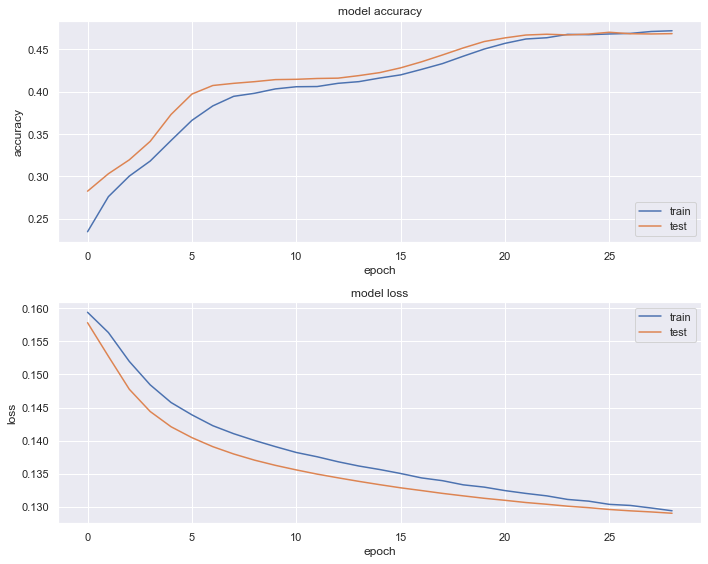

In [42]:
fig = plt.figure(figsize = (10,8))
plt.subplot(2,1,1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

Podemos observar que en la ultima epoca, la numero 29, se obtienen los mejores valores de accuracy y de MSE. Podemos ver como empiezan a estar levemente separadas, por lo que se pusieramos mas epocas, el modelo empezaria a hacer overfitting

Hacemos las predicciones sobre el train y test set y vemos el accuracy

In [44]:
y_train_pred_NN = model.predict(data_x_train)
y_test_pred_NN = model.predict(data_x_test)

#Sumamos 1 a las predicciones, ya que los vectores van de 0 a 4 y el Y va de 1 a 5
train_accuracy =  metrics.accuracy_score(y_train_pred_NN.argmax(axis=1)+1,ytrain)
test_accuracy =  metrics.accuracy_score(y_test_pred_NN.argmax(axis=1)+1, ytest)

print('Accuracy en el train set:', train_accuracy)
print('Accuracy en el test set:', test_accuracy)

Accuracy en el train set: 0.50361875
Accuracy en el test set: 0.468575


Vemos el RMSE del test set

In [45]:
mse5 = mean_squared_error(ytest,y_test_pred_NN.argmax(axis=1)+1)
rmse5 = math.sqrt(mse5)
print("RMSE: ",rmse5)

RMSE:  1.1574325034316255


Si comparamos los resultados de la red neuronal con el modelo random forest con sus hiperparametros optimizados (el mejor modelo con ML), podemos ver que:

+ Accuracy: Hay una mejora del 2,2% en este indicador
+ RMSE: Hay una mejora del ~5% en este indicador

### B - Probemos con los datos vectorizados, habiendo hecho un tratamiento de datos con la tecnica de lemmanzitation

Juntamos en una sola celda todos los tratamientos de datos realizados. Esto incluye el one hot encodding de las variables a predecir y la normalizacion de las variables predictoras

In [46]:
print("Train matrix shape",xtrain1.shape)
print("Test matrix shape", ytrain1.shape)

values,counts = np.unique(ytrain1, return_counts=True)
print("Values:", values)
print("Counts:", counts)

print("Shape of y_train [before one-hot encoding]: ", ytrain1.shape)
Y_train1 = pd.get_dummies(ytrain1)
Y_test1 = pd.get_dummies(ytest1)
print("Shape of Y_train [after one-hot encoding]: ", Y_train1.shape)

# normalizing the data to help with the training
scaler = MinMaxScaler()
data_x_train1 = scaler.fit_transform(xtrain1)
data_x_test1 = scaler.fit_transform(xtest1)

Train matrix shape (160000, 2500)
Test matrix shape (160000,)
Values: [1 2 3 4 5]
Counts: [32000 32000 32000 32000 32000]
Shape of y_train [before one-hot encoding]:  (160000,)
Shape of Y_train [after one-hot encoding]:  (160000, 5)


Creamos el modelo secuencial, con dos hidden layers y una layer de salida. El layer de salida tiene 5 neuronas (Las calificaciones van de 1 a 5) con una activacion softmax por ser un problema de clasificacion.
Tambien, tenemos dos capas de drop out lo que nos permite regular el overfitting.

In [47]:
model1 = Sequential()

model1.add(Dense(56, input_shape=(2500,), activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(8, activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(5, activation='softmax'))

Compilamos el modelo. La funcion de costo que vamos a utilizar es el mean squeare error y la metrica elegida es el accuracy. Como optimizador de la funcion de costo, vamos a utilizar la tecnica adam, modificando el learning rate que viene por defecto ya que nos permite tener mejores resultados

In [48]:
model1.compile(loss='MSE', metrics=['categorical_accuracy'], optimizer=keras.optimizers.Adam(lr=0.0001))

Vemos el resumen del modelo. Tiene un total de 140557 parametros para aprender

In [49]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 56)                140056    
_________________________________________________________________
dropout_2 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 456       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 45        
Total params: 140,557
Trainable params: 140,557
Non-trainable params: 0
_________________________________________________________________


Entrenamos el modelo y vemos los resultados. En este caso tenemos menos epocas que el modelo anterior ya que empezaba a hacer overfitting

In [50]:
history = model1.fit(data_x_train1, Y_train1,
          batch_size=1024, epochs=24,
          verbose=1,
          validation_data=(data_x_test1, Y_test1))

Epoch 1/24
157/157 [==============================] - 3s 13ms/step - loss: 0.1598 - categorical_accuracy: 0.2210 - val_loss: 0.1583 - val_categorical_accuracy: 0.3446
Epoch 2/24
157/157 [==============================] - 2s 12ms/step - loss: 0.1578 - categorical_accuracy: 0.3142 - val_loss: 0.1536 - val_categorical_accuracy: 0.4140
Epoch 3/24
157/157 [==============================] - 2s 12ms/step - loss: 0.1536 - categorical_accuracy: 0.3637 - val_loss: 0.1475 - val_categorical_accuracy: 0.4228
Epoch 4/24
157/157 [==============================] - 2s 12ms/step - loss: 0.1488 - categorical_accuracy: 0.3815 - val_loss: 0.1419 - val_categorical_accuracy: 0.4258
Epoch 5/24
157/157 [==============================] - 2s 12ms/step - loss: 0.1443 - categorical_accuracy: 0.3939 - val_loss: 0.1379 - val_categorical_accuracy: 0.4302
Epoch 6/24
157/157 [==============================] - 2s 11ms/step - loss: 0.1413 - categorical_accuracy: 0.4026 - val_loss: 0.1351 - val_categorical_accuracy: 0.440

Vamos a graficar como fue variando el accuracy y la funcion de costo en las distintas epocas

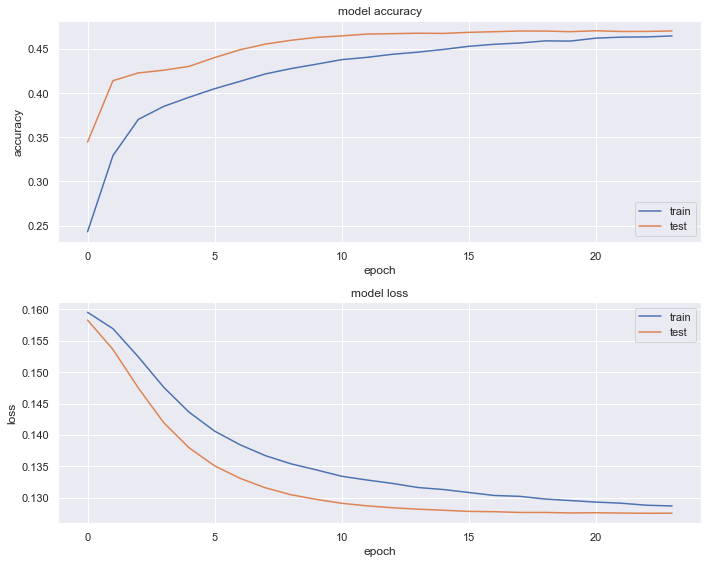

In [51]:
fig = plt.figure(figsize = (10,8))
plt.subplot(2,1,1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

Podemos observar que en la ultima epoca, la numero 24, se obtienen los mejores valores de accuracy y de MSE. Podemos ver como empiezan a estar levemente separadas, por lo que se pusieramos mas epocas, el modelo empezaria a hacer overfitting

Hacemos las predicciones para el train y el test set y vemos los resultados de accuracy

In [52]:
y_train_pred_NN1 = model1.predict(data_x_train1)
y_test_pred_NN1 = model1.predict(data_x_test1)


train_accuracy1 =  metrics.accuracy_score(y_train_pred_NN1.argmax(axis=1)+1,ytrain1)
test_accuracy1 =  metrics.accuracy_score(y_test_pred_NN1.argmax(axis=1)+1, ytest1)

print('Accuracy en el train set:', train_accuracy1)
print('Accuracy en el test set:', test_accuracy1)

Accuracy en el train set: 0.49918125
Accuracy en el test set: 0.470225


Vemos los resultados del RMSE

In [53]:
mse51 = mean_squared_error(ytest1,y_test_pred_NN1.argmax(axis=1)+1)
rmse51 = math.sqrt(mse51)
print("RMSE: ",rmse51)

RMSE:  1.140361784698172


Si comparamos los resultados de la red neuronal con el modelo random forest con sus hiperparametros optimizados (el mejor modelo con ML), podemos ver que:

+ Accuracy: Hay una mejora del 4,4% en este indicador
+ RMSE: Hay una mejora del ~6% en este indicador

Con esto, podemos concluir que el modelo que mejor resultados obtiene es una red neuronal con una previa lemmanzitation de datos. En el 47% de las predicciones lo hace de manera exacta y en aquellas que no lo hace, predice con un error promedio de 1.15

##### Como respuesta a la pregunta planteada, podemos decir que si se pueden mejorar los resultados del modelo aplicando una reu neuronal.

##### Estas mejoras se pueden ver en los dos indicadores de performance propuestos (accuracy y RMSE) pero tambien, es muy importante entender la reduccion de tiempo de procesamiento que se logro.
##### El modelo random search con sus hiperparametros optimizados, tardo en entrenarse 283 minutos (casi 5 horas), en cambio, la red neuronal tardo aproximadamente 1 minuto. Esto quiere decir que se redujo casi el 100% del tiempo de entrenamiento.

# 2- ¿Se pueden mejorar los resultados del modelo de deep learning agrandando la cantidad de features predictores?

#### A - Volvemos a vectorizar las palabras previamente stemizadas, con el objetivo de agrandar el tamaño de vector

Duplicamos el tamaño del vector, pasamos de 2500 a 5000

In [54]:
max_features = 5000
cou_vec=CountVectorizer(max_features=max_features,ngram_range=(1, 2))

list_reviews = list(dataset_stem['review_stem'].values)
stars = dataset_stem['stars'].values

matriz_reviews = cou_vec.fit_transform(list_reviews)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()


print("Las 50 palabras mas usadas son: ",all_words[0:50])

Las 50 palabras mas usadas son:  ['abaj', 'abertur', 'abiert', 'aboll', 'abon', 'abra', 'abre', 'abren', 'abres', 'abri', 'abrig', 'abril', 'abrir', 'abrir caj', 'abrir cerr', 'abrir paquet', 'abrirl', 'abro', 'abroch', 'absolut', 'absorb', 'absurd', 'abuel', 'abult', 'aburr', 'acab', 'acab buen', 'acab compr', 'acab gust', 'acab lleg', 'acab recib', 'acab romp', 'acas', 'acced', 'acces', 'accesori', 'acci', 'accident', 'accion', 'aceit', 'acept', 'acept preci', 'acer', 'acer inoxid', 'acerc', 'acert', 'aciert', 'aclar', 'acolch', 'acomp']


Creamos los nuevos dataset de train y test

In [55]:
x = matriz_reviews.toarray()
y = stars
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

Juntamos en una sola celda todos los tratamientos de datos realizados. Esto incluye el one hot encodding de las variables a predecir y la normalizacion de las variables predictoras

In [56]:
print("Train matrix shape",xtrain2.shape)
print("Test matrix shape", ytrain2.shape)

values,counts = np.unique(ytrain2, return_counts=True)
print("Values:", values)
print("Counts:", counts)

print("Shape of y_train [before one-hot encoding]: ", ytrain2.shape)
Y_train2 = pd.get_dummies(ytrain2)
Y_test2 = pd.get_dummies(ytest2)
print("Shape of Y_train [after one-hot encoding]: ", Y_train2.shape)

# normalizing the data to help with the training
scaler = MinMaxScaler()
data_x_train2 = scaler.fit_transform(xtrain2)
data_x_test2 = scaler.fit_transform(xtest2)

Train matrix shape (160000, 5000)
Test matrix shape (160000,)
Values: [1 2 3 4 5]
Counts: [32000 32000 32000 32000 32000]
Shape of y_train [before one-hot encoding]:  (160000,)
Shape of Y_train [after one-hot encoding]:  (160000, 5)


Creamos el modelo secuencial, con dos hidden layers y una layer de salida. El layer de salida tiene 5 neuronas (Las calificaciones van de 1 a 5) con una activacion softmax por ser un problema de clasificacion.
Tambien, tenemos dos capas de drop out lo que nos permite regular el overfitting.

In [57]:
model2 = Sequential()

model2.add(Dense(56, input_shape=(5000,), activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(8, activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(5, activation='softmax'))

Compilamos el modelo. La funcion de costo que vamos a utilizar es el mean squeare error y la metrica elegida es el accuracy. Como optimizador de la funcion de costo, vamos a utilizar la tecnica adam, modificando el learning rate que viene por defecto ya que nos permite tener mejores resultados

In [58]:
model2.compile(loss='MSE', metrics=['categorical_accuracy'], optimizer=keras.optimizers.Adam(lr=0.0001))

Vemos el resumen del modelo. Tiene un total de 280557 parametros para aprender

In [59]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 56)                280056    
_________________________________________________________________
dropout_4 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 456       
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 45        
Total params: 280,557
Trainable params: 280,557
Non-trainable params: 0
_________________________________________________________________


Entrenamos el modelo y vemos los resultados. Notar que tiene la misma cantidad de epocas y batch size que el modelo creado para menos features, con el objetivo de que sean comparables

In [60]:
history2 = model2.fit(data_x_train2, Y_train2,
          batch_size=1024, epochs=29,
          verbose=1,
          validation_data=(data_x_test2, Y_test2))

Epoch 1/29
157/157 [==============================] - 6s 33ms/step - loss: 0.1599 - categorical_accuracy: 0.2182 - val_loss: 0.1587 - val_categorical_accuracy: 0.2840
Epoch 2/29
157/157 [==============================] - 3s 22ms/step - loss: 0.1584 - categorical_accuracy: 0.2846 - val_loss: 0.1557 - val_categorical_accuracy: 0.3388
Epoch 3/29
157/157 [==============================] - 3s 21ms/step - loss: 0.1555 - categorical_accuracy: 0.3274 - val_loss: 0.1514 - val_categorical_accuracy: 0.3648
Epoch 4/29
157/157 [==============================] - 3s 21ms/step - loss: 0.1518 - categorical_accuracy: 0.3490 - val_loss: 0.1468 - val_categorical_accuracy: 0.3834
Epoch 5/29
157/157 [==============================] - 3s 21ms/step - loss: 0.1478 - categorical_accuracy: 0.3741 - val_loss: 0.1428 - val_categorical_accuracy: 0.4127
Epoch 6/29
157/157 [==============================] - 3s 21ms/step - loss: 0.1446 - categorical_accuracy: 0.3931 - val_loss: 0.1397 - val_categorical_accuracy: 0.429

Vamos a graficar como fue variando el accuracy y la funcion de costo en las distintas epocas

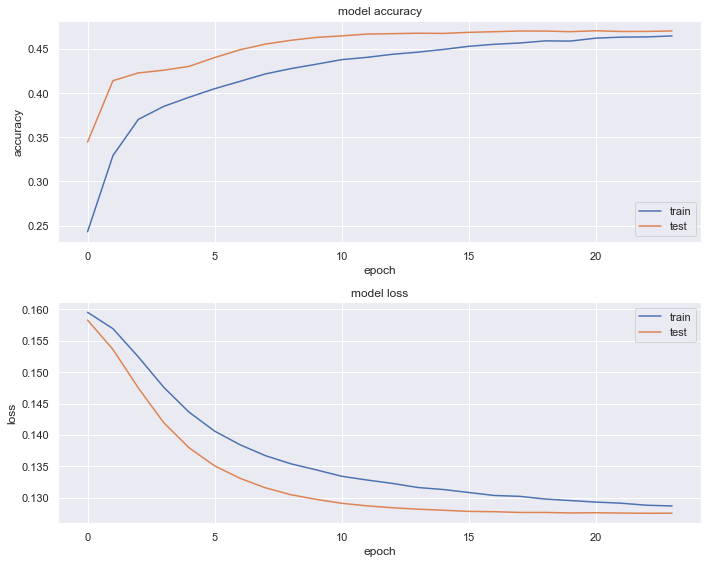

In [61]:
fig = plt.figure(figsize = (10,8))
plt.subplot(2,1,1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

Podemos observar que en la ultima epoca, la numero 24, se obtienen los mejores valores de accuracy y de MSE. Podemos ver como empiezan a estar levemente separadas, por lo que se pusieramos mas epocas, el modelo empezaria a hacer overfitting

Hacemos las predicciones sobre el train y test set y vemos el accuracy

In [62]:
y_train_pred_NN2 = model2.predict(data_x_train2)
y_test_pred_NN2 = model2.predict(data_x_test2)

train_accuracy2 =  metrics.accuracy_score(y_train_pred_NN2.argmax(axis=1)+1,ytrain2)
test_accuracy2 =  metrics.accuracy_score(y_test_pred_NN2.argmax(axis=1)+1, ytest2)

print('Accuracy en el train set:', train_accuracy2)
print('Accuracy en el test set:', test_accuracy2)

Accuracy en el train set: 0.53466875
Accuracy en el test set: 0.480475


Vemos el RMSE del modelo

In [63]:
mse6 = mean_squared_error(ytest2,y_test_pred_NN2.argmax(axis=1)+1)
rmse6 = math.sqrt(mse6)
print("RMSE: ",rmse6)

RMSE:  1.124655502809638


Si comparamos los resultados de la red neuronal entrenada con 2500 features con la red neuronal entrenada por 5000 features, podemos ver que:

+ Accuracy: Hay una mejora del 2,6% en este indicador cuando se entrena con mas features
+ RMSE: Hay una mejora del 3,3% en este indicador cuando se entrena con mas features

#### B - Volvemos a vectorizar las palabras previamente lemmantizadas, con el objetivo de agrandar el tamaño de vector

Creamos el nuevo vector duplicando la cantidad de features. Pasamos de 2500 a 5000

In [64]:
max_features= 5000
cou_vec2=CountVectorizer(max_features=max_features,ngram_range=(1, 2))

list_reviews1 = list(dataset_lemm['review_lemm'].values)
stars1 = dataset_lemm['stars'].values

matriz_reviews2 = cou_vec2.fit_transform(list_reviews1)

# Tomamos las palabras
all_words = cou_vec1.get_feature_names()


print("Las 50 palabras mas usadas son: ",all_words[0:50])

Las 50 palabras mas usadas son:  ['abajo', 'abierta', 'abierto', 'abre', 'abril', 'abrir', 'abrirlo', 'absolutamente', 'absoluto', 'absorbe', 'acab', 'acaba', 'acabado', 'acabados', 'acaban', 'acabar', 'acabo', 'accesorio', 'accesorios', 'aceite', 'aceptable', 'acero', 'acierto', 'acolchado', 'aconsejable', 'aconsejo', 'acopla', 'acorde', 'adapta', 'adapta bien', 'adapta perfectamente', 'adaptador', 'adaptan', 'adecuada', 'adecuado', 'adelante', 'adem', 'ademas', 'adhesivo', 'adhiere', 'adir', 'adjunto', 'adulto', 'agarra', 'agarre', 'agenda', 'agosto', 'agradable', 'agradable tacto', 'agradece']


Volvemos a crear el dataset de train y test

In [65]:
x3 = matriz_reviews2.toarray()
y3 = stars1
xtrain3, xtest3, ytrain3, ytest3 = train_test_split(x3,y3,test_size=0.2,random_state=42,stratify=y)

Juntamos en una sola celda todos los tratamientos de datos realizados. Esto incluye el one hot encodding de las variables a predecir y la normalizacion de las variables predictoras

In [66]:
print("Train matrix shape",xtrain3.shape)
print("Test matrix shape", ytrain3.shape)

values,counts = np.unique(ytrain3, return_counts=True)
print("Values:", values)
print("Counts:", counts)

print("Shape of y_train [before one-hot encoding]: ", ytrain3.shape)
Y_train3 = pd.get_dummies(ytrain3)
Y_test3 = pd.get_dummies(ytest3)
print("Shape of Y_train [after one-hot encoding]: ", Y_train3.shape)

scaler = MinMaxScaler()
data_x_train3 = scaler.fit_transform(xtrain3)
data_x_test3 = scaler.fit_transform(xtest3)

Train matrix shape (160000, 5000)
Test matrix shape (160000,)
Values: [1 2 3 4 5]
Counts: [32000 32000 32000 32000 32000]
Shape of y_train [before one-hot encoding]:  (160000,)
Shape of Y_train [after one-hot encoding]:  (160000, 5)


Creamos el modelo secuencial, con dos hidden layers y una layer de salida. El layer de salida tiene 5 neuronas (Las calificaciones van de 1 a 5) con una activacion softmax por ser un problema de clasificacion.
Tambien, tenemos dos capas de drop out lo que nos permite regular el overfitting.

In [67]:
model3 = Sequential()

model3.add(Dense(56, input_shape=(5000,), activation='relu'))
model3.add(Dropout(0.2))

model3.add(Dense(8, activation='relu'))
model3.add(Dropout(0.2))

model3.add(Dense(5, activation='softmax'))

Compilamos el modelo. La funcion de costo que vamos a utilizar es el mean squeare error y la metrica elegida es el accuracy. Como optimizador de la funcion de costo, vamos a utilizar la tecnica adam, modificando el learning rate que viene por defecto ya que nos permite tener mejores resultados

In [68]:
model3.compile(loss='MSE', metrics=['categorical_accuracy'], optimizer=keras.optimizers.Adam(lr=0.0001))

Vemos el resumen del modelo. Tiene un total de 280557 parametros para aprender

In [69]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 56)                280056    
_________________________________________________________________
dropout_6 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 456       
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 45        
Total params: 280,557
Trainable params: 280,557
Non-trainable params: 0
_________________________________________________________________


Entrenamos el modelo y vemos los resultados. Notar que tiene el mismo batch size y epocas que el modelo anterior, para que los resultados sean comparables

In [70]:
history3 = model3.fit(data_x_train3, Y_train3,
          batch_size=1024, epochs=24,
          verbose=1,
          validation_data=(data_x_test3, Y_test3))

Epoch 1/24
157/157 [==============================] - 6s 29ms/step - loss: 0.1598 - categorical_accuracy: 0.2185 - val_loss: 0.1584 - val_categorical_accuracy: 0.2947
Epoch 2/24
157/157 [==============================] - 3s 22ms/step - loss: 0.1579 - categorical_accuracy: 0.2924 - val_loss: 0.1544 - val_categorical_accuracy: 0.4165
Epoch 3/24
157/157 [==============================] - 3s 21ms/step - loss: 0.1542 - categorical_accuracy: 0.3717 - val_loss: 0.1487 - val_categorical_accuracy: 0.4452
Epoch 4/24
157/157 [==============================] - 3s 21ms/step - loss: 0.1494 - categorical_accuracy: 0.3982 - val_loss: 0.1431 - val_categorical_accuracy: 0.4451
Epoch 5/24
157/157 [==============================] - 3s 21ms/step - loss: 0.1447 - categorical_accuracy: 0.4102 - val_loss: 0.1388 - val_categorical_accuracy: 0.4469
Epoch 6/24
157/157 [==============================] - 3s 20ms/step - loss: 0.1414 - categorical_accuracy: 0.4140 - val_loss: 0.1359 - val_categorical_accuracy: 0.450

Vamos a graficar como fue variando el accuracy y la funcion de costo en las distintas epocas

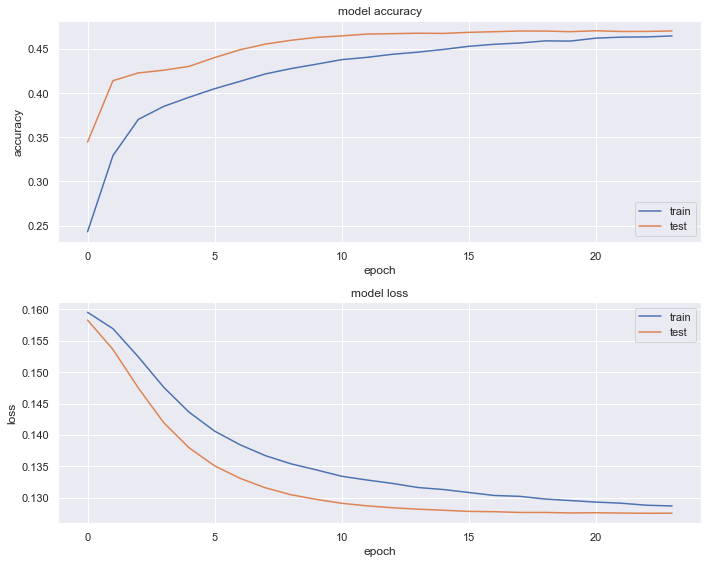

In [71]:
fig = plt.figure(figsize = (10,8))
plt.subplot(2,1,1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

Podemos observar que en la ultima epoca, la numero 24, se obtienen los mejores valores de accuracy y de MSE. Podemos ver como empiezan a estar levemente separadas, por lo que se pusieramos mas epocas, el modelo empezaria a hacer overfitting

Hacemos las predicciones sobre ambos datasets y vemos el accuracy

In [72]:
y_train_pred_NN3 = model3.predict(data_x_train3)
y_test_pred_NN3 = model3.predict(data_x_test3)

train_accuracy3 =  metrics.accuracy_score(y_train_pred_NN3.argmax(axis=1)+1,ytrain3)
test_accuracy3 =  metrics.accuracy_score(y_test_pred_NN3.argmax(axis=1)+1, ytest3)

print('Accuracy en el train set:', train_accuracy3)
print('Accuracy en el test set:', test_accuracy3)

Accuracy en el train set: 0.52648125
Accuracy en el test set: 0.4755


Vemos el RMSE

In [73]:
mse53 = mean_squared_error(ytest3,y_test_pred_NN3.argmax(axis=1)+1)
rmse53 = math.sqrt(mse53)
print("RMSE: ",rmse53)

RMSE:  1.1208144360240904


Si comparamos los resultados de la red neuronal entrenada con 2500 features con la red neuronal entrenada por 5000 features, podemos ver que:

+ Accuracy: Hay una mejora del 1,5% en este indicador cuando se entrena con mas features
+ RMSE: Hay una mejora del 4,3% en este indicador cuando se entrena con mas features

Viendo estos resultados, el modelo con el cual obtenemos los mejores resultados en las metricas elegidas es una red neuronal, habiendo hecho la preparacion de datos con la tecnica de lemmanzitation y utilizando 5000 features para entrenarla

##### Como respuesta a la pregunta planteada, si es posible obtener mejores resultados con el mismo modelo si agregamos mas features al entrenamiento. La parte no tan positiva de esto es que, el tiempo de procesamiento se duplico, es decir, que tardo dos minutos en entrenarse.

#### Como conclusion, podemos decir que pudimos validar ambas hipotesis planteadas. Con una red neuronal pudimos mejorar los resultados del modelo de machine learning y al haber agregado features predictores, el modelo mejoro aun mas.

Aclaracion: La optimizacion de las redes neuronales se hizo de manera manual. Se probaron redes con mas y menos layers, con mas y menos neuronas, se probaron distintos tipos de optimizadores y a su vez, con distintos learning rates. Tambien se probo el entrenamiento con distintas batch sizes y epocas. Las redes presentadas son las que mejores resultados obtuvieron luego de ~50 iteraciones.